## Homework 4

Adam Grabowski |
CS 541 Deep Learning |
September 29, 2023

In [248]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize
from sklearn.decomposition import PCA
from torch.nn.functional import one_hot
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder

### Problem 1

In [249]:
# Architecture
NUM_HIDDEN_LAYERS = 3
NUM_INPUT = 784
NUM_HIDDEN = 10
NUM_OUTPUT = 10

# Hyperparameters
NUM_EPOCHS = 20
BATCH_SIZE = 100
LEARNING_RATE = 0.01
REG_STRENGTH = 0.0001

In [250]:
def unpack(weightsAndBiases):
    # Weight matrices and bias vectors
    Ws = []
    bs = []

    # Unpack weight matrices for input layer
    start = 0
    end = NUM_INPUT * NUM_HIDDEN
    W = weightsAndBiases[start:end]
    Ws.append(W)

    # Unpack weight matrices for hidden layers
    for i in range(NUM_HIDDEN_LAYERS - 1):
        start = end
        end = end + NUM_HIDDEN * NUM_HIDDEN
        W = weightsAndBiases[start:end]
        Ws.append(W)

    # Unpack weight matrix for output layer
    start = end
    end = end + NUM_HIDDEN * NUM_OUTPUT
    W = weightsAndBiases[start:end]
    Ws.append(W)

    # Reshape weight matrices to match layer dimensions
    Ws[0] = Ws[0].reshape(NUM_HIDDEN, NUM_INPUT)
    for i in range(1, NUM_HIDDEN_LAYERS):
        Ws[i] = Ws[i].reshape(NUM_HIDDEN, NUM_HIDDEN)
    Ws[-1] = Ws[-1].reshape(NUM_OUTPUT, NUM_HIDDEN)

    # Unpack bias vectors for input layer
    bs = []
    start = end
    end = end + NUM_HIDDEN
    b = weightsAndBiases[start:end]
    bs.append(b)

    # Unpack bias vectors for hidden layers
    for i in range(NUM_HIDDEN_LAYERS - 1):
        start = end
        end = end + NUM_HIDDEN
        b = weightsAndBiases[start:end]
        bs.append(b)

    # Unpack bias vector for output layer
    start = end
    end = end + NUM_OUTPUT
    b = weightsAndBiases[start:end]
    bs.append(b)

    return Ws, bs

In [251]:
def relu(z):
    # ReLU activation
    return np.maximum(0, z)

In [252]:
def softmax(z):
    # Softmax activation
    exp_z = np.exp(z - np.max(z, axis=0))
    return exp_z / np.sum(exp_z, axis=0)

In [253]:
def crossEntropyLoss(y, yhat):
    # Cross-entropy loss
    n = y.shape[0]
    loss = -np.sum(y * np.log(yhat) + (1 - y) * np.log(1 - yhat)) / n
    return loss

In [254]:
def forwardProp(x, y, weightsAndBiases):
    # Unpack weights and biases
    Ws, bs = unpack(weightsAndBiases)

    # Pre and post activation layers
    zs = []
    hs = []
    act = x

    # Predict hidden and input layers
    for i in range(NUM_HIDDEN_LAYERS):
        z = np.dot(Ws[i], act) + bs[i].reshape(-1, 1)
        h = relu(z)
        zs.append(z)
        hs.append(h)
        act = h

    # Predict output layer
    z = np.dot(Ws[-1], hs[-1]) + bs[-1].reshape(-1, 1)
    zs.append(z)
    yhat = softmax(z)

    # Compute cross-entropy loss
    loss = crossEntropyLoss(y, yhat)

    return loss, zs, hs, yhat

In [255]:
def reluDeriv(z):
    # ReLU activation derivative
    return np.where(z > 0, 1, 0)

In [256]:
def softmaxDeriv(z):
    # Softmax activation derivative
    return z * (1 - z)

In [257]:
def backProp(x, y, weightsAndBiases):
    # Unpack weights and biases
    Ws, bs = unpack(weightsAndBiases)

    # Forward propagation
    loss, zs, hs, yhat = forwardProp(x, y, weightsAndBiases)

    # Gradients w.r.t. weights and biases
    dJdWs = []
    dJdbs = []
    n = x.shape[1]

    # Back propagate output layer
    delta = (yhat - y) * softmaxDeriv(zs[-1])
    dJdWi = -np.dot(delta, hs[-1].T) / n
    dJdbi = -np.sum(delta, axis=1) / n
    dJdWs.append(dJdWi)
    dJdbs.append(dJdbi)

    # Backpropagate hidden and input layers
    for i in range(NUM_HIDDEN_LAYERS, 0, -1):
        if i == 1: # Input layer
            delta = np.dot(Ws[i], delta) * reluDeriv(zs[i - 1])
            dJdWi = -np.dot(delta, x.T) / n
            dJdbi = -np.sum(delta, axis=1) / n
        else: # Hidden layer
            delta = np.dot(Ws[i], delta) * reluDeriv(zs[i - 1])
            dJdWi = -np.dot(delta, hs[i - 1].T) / n
            dJdbi = -np.sum(delta, axis=1) / n

        # Append gradients to lists
        dJdWs.append(dJdWi)
        dJdbs.append(dJdbi)

    # Reverse lists to match layer order
    dJdWs = dJdWs[::-1]
    dJdbs = dJdbs[::-1]

    # Concatenate gradients
    gradients = np.hstack([dJdW.flatten() for dJdW in dJdWs] + [dJdb.flatten() for dJdb in dJdbs])

    return gradients

In [258]:
def train(trainX, trainY, weightsAndBiases, valX, valY):
    # Trajectory and number of samples
    trajectory = []
    n = trainX.shape[1]

    for epoch in range(NUM_EPOCHS):
        # Shuffle indices for each epoch
        perm = np.random.permutation(n)

        for i in range(0, n, BATCH_SIZE):
            # Select batch of training examples using indices
            batchIndices = perm[i:i + BATCH_SIZE]
            batchX = trainX[:, batchIndices]
            batchY = trainY[:, batchIndices]

            # Forward and backward propagation to compute gradients
            gradients = backProp(batchX, batchY, weightsAndBiases)

            # Update weights and biases using gradients and learning rate
            weightsAndBiases = weightsAndBiases - LEARNING_RATE * gradients

        # Append current weights and biases to trajectory
        trajectory.append(weightsAndBiases.copy())

        # Compute and print loss for epoch
        loss, _, _, _ = forwardProp(trainX, trainY, weightsAndBiases)
        print(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Train Loss: {loss:.4f}")

    return weightsAndBiases, trajectory

In [259]:
def initWeightsAndBiases():
    # Set fixed random seed
    Ws = []
    bs = []
    np.random.seed(0)

    # Initialize weights and biases for input layer
    W = 2 * (np.random.random(size=(NUM_HIDDEN, NUM_INPUT)) / NUM_INPUT ** 0.5) - 1. / NUM_INPUT ** 0.5
    Ws.append(W)
    b = 0.01 * np.ones(NUM_HIDDEN)
    bs.append(b)

    # Initialize weights and biases for hidden layers
    for i in range(NUM_HIDDEN_LAYERS - 1):
        W = 2 * (np.random.random(size=(NUM_HIDDEN, NUM_HIDDEN)) / NUM_HIDDEN ** 0.5) - 1. / NUM_HIDDEN ** 0.5
        Ws.append(W)
        b = 0.01 * np.ones(NUM_HIDDEN)
        bs.append(b)

    # Initialize weights and biases for output layer
    W = 2 * (np.random.random(size=(NUM_OUTPUT, NUM_HIDDEN)) / NUM_HIDDEN ** 0.5) - 1. / NUM_HIDDEN ** 0.5
    Ws.append(W)
    b = 0.01 * np.ones(NUM_OUTPUT)
    bs.append(b)

    # Concatenate weight matrices and bias vectors into array
    return np.hstack([W.flatten() for W in Ws] + [b.flatten() for b in bs])

In [260]:
def oneHot(labels, numClasses):
    # One-hot encoding
    one_hot_encoded = np.eye(numClasses)[labels]
    return one_hot_encoded

In [262]:
# Load train and test data
trainX = np.load("fashion_mnist_train_images.npy").T / 255. - 0.5
trainY = oneHot(np.load("fashion_mnist_train_labels.npy"), 10).T
testX = np.load("fashion_mnist_test_images.npy").T / 255. - 0.5
testY = oneHot(np.load("fashion_mnist_test_labels.npy"), 10).T

# Initialize weights and biases
weightsAndBiases = initWeightsAndBiases()

# Perform gradient check on 5 training examples
gradCheck = scipy.optimize.check_grad(lambda wab: forwardProp(np.atleast_2d(trainX[:,0:5]), np.atleast_2d(trainY[:,0:5]), wab)[0],
                                      lambda wab: backProp(np.atleast_2d(trainX[:,0:5]), np.atleast_2d(trainY[:,0:5]), wab), weightsAndBiases)
print(f"Gradient Check: {gradCheck}")

# Train neural network
weightsAndBiases, trajectory = train(trainX, trainY, weightsAndBiases, testX, testY)

# Forward propagation to compute loss
loss, _, _, _ = forwardProp(testX, testY, weightsAndBiases)
print(f"Test Loss: {loss}")

Gradient Check: 0.6038651698502733
Epoch 1/20, Train Loss: 19499.4005
Epoch 2/20, Train Loss: 19496.5621
Epoch 3/20, Train Loss: 19494.3721
Epoch 4/20, Train Loss: 19492.7158
Epoch 5/20, Train Loss: 19490.2256
Epoch 6/20, Train Loss: 19488.0270
Epoch 7/20, Train Loss: 19480.9469
Epoch 8/20, Train Loss: 19473.5530
Epoch 9/20, Train Loss: 19467.7583
Epoch 10/20, Train Loss: 19463.2445
Epoch 11/20, Train Loss: 19455.4375
Epoch 12/20, Train Loss: 19448.5366
Epoch 13/20, Train Loss: 19447.0251
Epoch 14/20, Train Loss: 19448.1970
Epoch 15/20, Train Loss: 19446.6194
Epoch 16/20, Train Loss: 19442.7918
Epoch 17/20, Train Loss: 19439.0250
Epoch 18/20, Train Loss: 19442.9704
Epoch 19/20, Train Loss: 19459.8110
Epoch 20/20, Train Loss: 19481.0938
Test Loss: 3246.7062922808263


### Problem 2

In [265]:
def createAndTrainModel(hiddenLayers, hiddenUnits, learningRate, batchSize, numEpochs, regStrength, trainX, trainY):
    # Define neural network model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(784,)))

    # Add hidden layers with specified units and ReLU activation
    for _ in range(hiddenLayers):
        model.add(tf.keras.layers.Dense(hiddenUnits, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(regStrength)))

    # Add output layer with 10 units and softmax activation
    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    # Compile model with SGD optimizer and cross-entropy loss
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learningRate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Train model on training data
    history = model.fit(trainX, trainY, epochs=numEpochs, batch_size=batchSize, verbose=0)

    return model, history

In [266]:
def findBestHyperparameters(trainX, trainY, valX, valY):
    # Define hyperparameter ranges
    hiddenLayersRange = [3, 4, 5]
    hiddenUnitsRange = [30, 40]
    learningRateRange = [0.05]
    batchSizeRange = [64, 128]
    numEpochsRange = [20, 40]
    regStrengthRange = [0.001]

    # Initialize best hyperparameters and accuracy
    bestAccuracy = 0
    bestHyperparams = {}

    # Loop through hyperparameter combinations
    for hiddenLayers in hiddenLayersRange:
        for hiddenUnits in hiddenUnitsRange:
            for learningRate in learningRateRange:
                for batchSize in batchSizeRange:
                    for numEpochs in numEpochsRange:
                        for regStrength in regStrengthRange:
                            # Train and evaluate model with hyperparameters
                            model = createAndTrainModel(hiddenLayers, hiddenUnits, learningRate, batchSize, numEpochs, regStrength, trainX, trainY)[0]

                            # Evaluate model on validation data to get accuracy
                            accuracy = model.evaluate(valX, valY, verbose=0)[1]

                            # Check if hyperparameter combination results in better accuracy
                            if accuracy > bestAccuracy:
                                bestAccuracy = accuracy
                                bestHyperparams = {
                                    'hiddenLayers': hiddenLayers,
                                    'hiddenUnits': hiddenUnits,
                                    'learningRate': learningRate,
                                    'batchSize': batchSize,
                                    'numEpochs': numEpochs,
                                    'regStrength': regStrength
                                }

    # Return best hyperparameters and corresponding accuracy
    return bestHyperparams, bestAccuracy

In [267]:
# Load train and test data
trainX2 = np.load("fashion_mnist_train_images.npy").reshape(-1, 28 * 28) / 255.0
trainY2 = OneHotEncoder(sparse_output=False).fit_transform(np.load("fashion_mnist_train_labels.npy").reshape(-1, 1))
testX2 = np.load("fashion_mnist_test_images.npy").reshape(-1, 28 * 28) / 255.0
testY2 = OneHotEncoder(sparse_output=False).fit_transform(np.load("fashion_mnist_test_labels.npy").reshape(-1, 1))

# Split train data into train and validation sets
trainX2, valX2, trainY2, valY2 = train_test_split(trainX2, trainY2, test_size=0.2, random_state=42)

# Get best hyperparameters and loss
bestHyperparams, bestAccuracy = findBestHyperparameters(trainX2, trainY2, valX2, valY2)

# Print best hyperparameters and validation accuracy
print("Best Hyperparameters:", bestHyperparams)
print("Validation Accuracy:", bestAccuracy)

Best Hyperparameters: {'hiddenLayers': 5, 'hiddenUnits': 40, 'learningRate': 0.05, 'batchSize': 64, 'numEpochs': 40, 'regStrength': 0.001}
Validation Accuracy: 0.8821666836738586


Test Accuracy: 0.8632000088691711


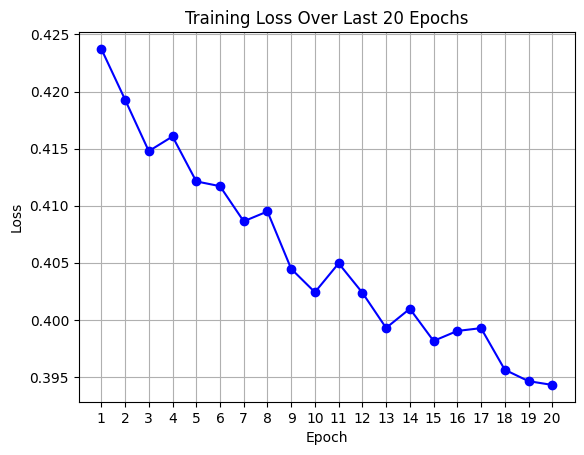

In [268]:
# Create and train model with best hyperparameters
model, history = createAndTrainModel(**bestHyperparams, trainX=trainX2, trainY=trainY2)

# Calculate test accuracy
accuracy = model.evaluate(testX2, testY2, verbose=0)[1]
print("Test Accuracy:", accuracy)

# Get last 20 training losses
trainLoss = history.history['loss'][-20:]
epochs = range(1, len(trainLoss) + 1)

# Plot training loss over last 20 epochs
plt.plot(epochs, trainLoss, marker='o', linestyle='-', color='b')
plt.title("Training Loss Over Last 20 Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.xticks(epochs)
plt.show()

### Problem 3

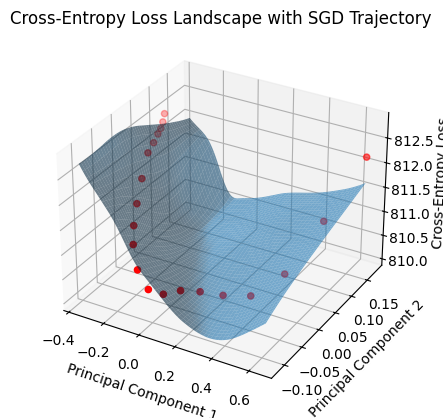

In [264]:
def plotSGDPath(trainX, trainY, trajectory):
    # Perform PCA on the trajectory to find principal components
    pca = PCA(n_components=2)
    components = pca.fit_transform(trajectory)

    # Create grid of points in 2-D PCA space
    axis1 = np.linspace(components[:, 0].min(), components[:, 0].max(), 100)
    axis2 = np.linspace(components[:, 1].min(), components[:, 1].max(), 100)
    Xaxis, Yaxis = np.meshgrid(axis1, axis2)
    Zaxis = np.zeros((len(axis1), len(axis2)))

    # Compute the CE loss on grid of points
    for i in range(len(axis1)):
        for j in range(len(axis2)):
            # Use inverse_transform to map from PCA space to parameter space
            parameters = pca.inverse_transform([Xaxis[i, j], Yaxis[i, j]])

            # Forward propagation to compute loss on training data
            loss, _, _, _ = forwardProp(trainX, trainY, parameters)

            # Set loss value in Zaxis grid
            Zaxis[i, j] = loss

    # Create 3-D plot
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # Plot loss landscape surface
    ax.plot_surface(Xaxis, Yaxis, Zaxis, alpha=0.6)

    # Calculate loss for each point on SGD trajectory
    losses = []
    for point in trajectory:
        loss, _, _, _ = forwardProp(trainXSub, trainYSub, point)
        losses.append(loss)

    # Plot SGD trajectory in 2-D PCA space
    ax.scatter(components[:, 0], components[:, 1], losses, color='r')

    # Set plot options
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    ax.set_zlabel("Cross-Entropy Loss")
    plt.title("Cross-Entropy Loss Landscape with SGD Trajectory")
    plt.show()

# Plot SGD path on subset
trainXSub = trainX[:, :2500]
trainYSub = trainY[:, :2500]
plotSGDPath(trainXSub, trainYSub, trajectory)